# The Kangerlussuaq Algorithm

In [1]:
import ka as ka
import numpy as np
import matplotlib.pyplot as plt

In [2]:
0.1**0.2

0.6309573444801932

# 1. Input 

## 1.1. Cable properties

In [3]:
# Number of initial interpolation points.
n=4

# Maximum total length.
L=7000.0

# Channel spacing [m].
dl=10.0

x0 =np.zeros(n)
x0[0]=0.0
x0[1]=1500.0
x0[2]=2500.0
x0[3]=0.0

y0= np.zeros(n)
y0[0]=-200.0
y0[1]=500.0
y0[2]=-200.0
y0[3]=-300.0

# Initial weights for maximum length of cable segments (<=1.0).
w0=np.ones(n-1)
#w0[0]=0.0
#w0[1]=0.2
# Exponent for the updating of weights (<=1.0).
m=1.0

## 1.2. Sources

In [4]:
# Number of sources.
ns=30

# Source locations.
xs = np.zeros(ns)
xs[0:10]=0.0
xs[10:20]=np.linspace(0.0,3000.0,10)
xs[20:30]=np.linspace(0.0,3000.0,10)

ys = np.zeros(ns)
ys[0:10]=np.linspace(1000.0,3000.0,10)
ys[10:20]=1000.0
ys[20:30]=np.linspace(1000.0,3000.0,10)

## 1.3. Random iteration parameters

In [5]:
# Maximum number of refinement stages.
nit=5

# Number of random trials per refinement stage.
N=5000

## 1.4. Offset and azimuth bins for optimisation

In [6]:
# Make offset bins.
bins_offset=np.arange(0.0,4000.0,300.0)
# Make azimuth bins.
bins_azimuth=np.arange(0.0,np.pi,np.pi/20.0)

## 1.5. Plot initial configuration

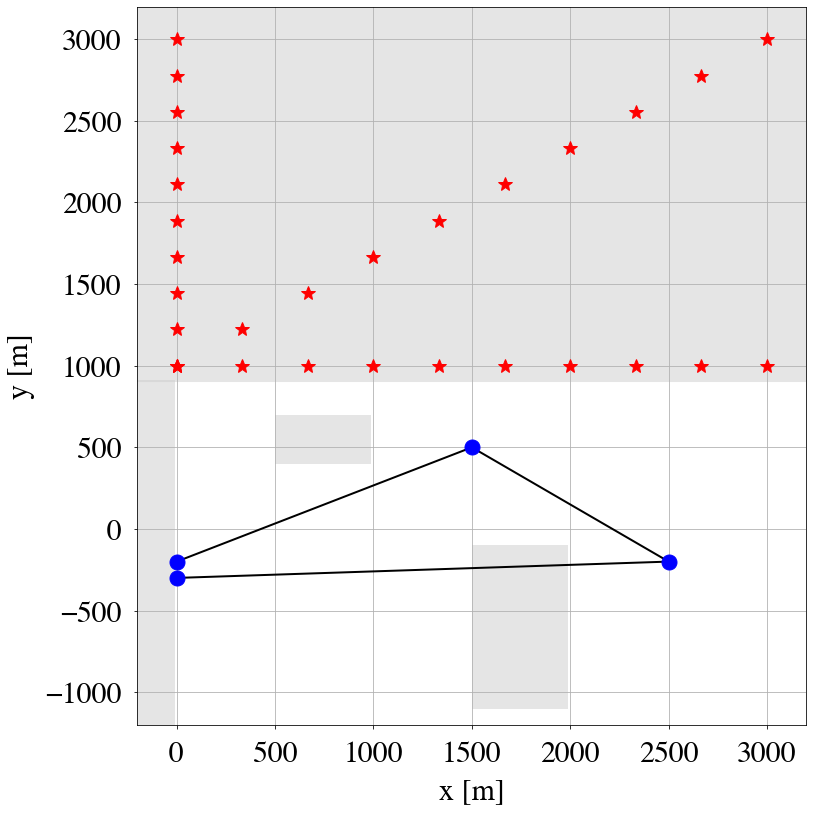

In [7]:
ka.plot(x0,y0,x0,y0,xs,ys,filename='./OUTPUT/initial_geometry.png')

In [8]:
xc,yc=ka.make_channel_coordinates(x0,y0,dl)

In [9]:
def chi_distance_azimuth(xs,ys,xc,yc,plot=False,filename=None):
    """
    Compute cost function in distance and azimuth for all pairs of source coordinates (xs, ys) and channel
    coordinates (xc,yc). 
    """
    
    nl=len(xc)
    l=np.sqrt((xc[1:nl]-xc[0:nl-1])**2 + (yc[1:nl]-yc[0:nl-1])**2)
    
    weights=[]
    d=[]
    phi=[]
    
    # March through all sources and compute distances and azimuths.
    for i in range(ns): 
                
        # Distance and azimuth per source.
        d_s=np.sqrt((xc[0:nl]-xs[i])**2+(yc[0:nl]-ys[i])**2)
        phi_s=np.arccos((xc[0:nl]-xs[i])/d_s)
        
        # Append to what we have so far.
        d=np.append(d,d_s)
        phi=np.append(phi,phi_s)
        
    # Check if any distance or azimuth fall into the bins. (Needed for histogram normalisation.)
    if np.min(d)<np.max(bins_offset) and np.max(d)>np.min(bins_offset) and np.min(phi)<np.max(bins_azimuth) and np.max(phi)>np.min(bins_azimuth): 
        bins_filled=True
    else:
        bins_filled=False
        
    # Make a 2D normalised histogram.
    hist,d_edges,phi_edges=np.histogram2d(d,phi,bins=[bins_offset,bins_azimuth],density=bins_filled)
    
    # Compute distance to the uniform distribution.
    if bins_filled:
        V=(bins_offset[-1]-bins_offset[0])*(bins_azimuth[-1]-bins_azimuth[0])
        chi=np.sum(np.abs(hist-1.0/V)**2)
    else: 
        chi=1.0
    
    # Plot 2D histogram.
    if plot:
        plt.figure(figsize=(12,12))
        plt.hist2d(d,180.0*phi/np.pi,bins=[bins_offset,180.0*bins_azimuth/np.pi],density=bins_filled,cmap='binary')
        plt.xlabel('offset [m]', labelpad=20)
        plt.ylabel('azimuth [deg]', labelpad=20)
        plt.colorbar()
        plt.clim(0.0,5.0e-6)
        plt.tight_layout()
        
        if filename: plt.savefig(filename,dpi=200,format='png')
        
        plt.show()
    
    # Return.
    return chi

5377.949297937415


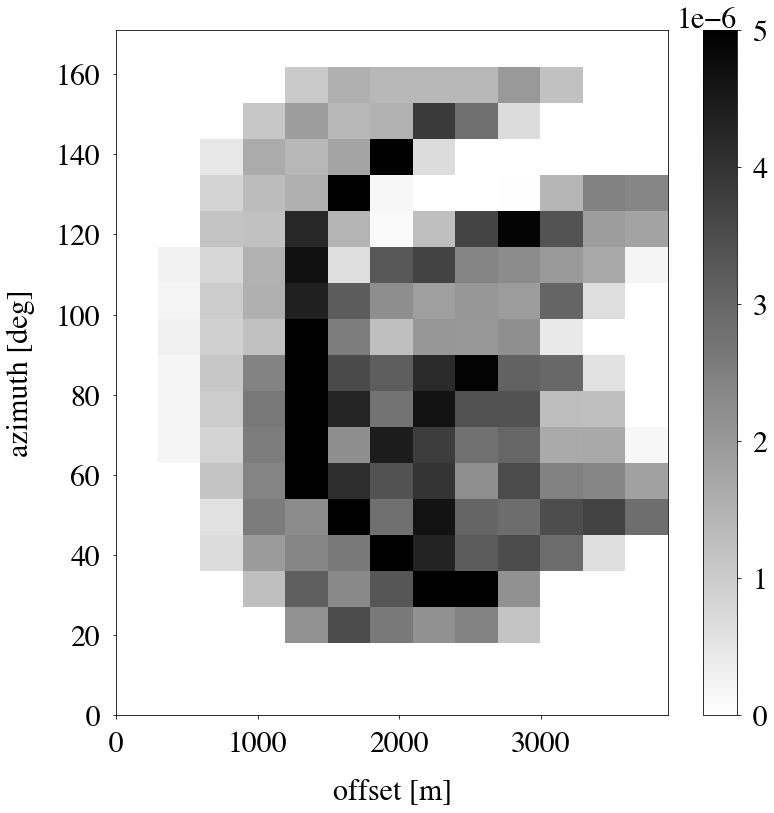

2.405495244536106e-06


In [10]:
# Initial state.

# Calculate initial length.
l=np.sqrt((x0[1:n]-x0[0:n-1])**2 + (y0[1:n]-y0[0:n-1])**2)
print(np.sum(l))

# Calculate initial misfit and histogram.
chi=chi_distance_azimuth(xs,ys,xc,yc,plot=True,filename='./OUTPUT/initial_histogram.png')
print(chi)

In [11]:
1.67e-6/2.405495244536106e-06

0.6942437337148242

In [17]:
1.58e-6/2.405495244536106e-06

0.656829400760133

In [12]:
# Loop over refinement stages.
for i in range(nit):
    
    print('--- refinement stage %d -------------------------' % i)
    
    # Set the initial cable configuration.
    if i==0:
        x_init=x0.copy()
        y_init=y0.copy()
        w_init=w0.copy()
        chi_opt=chi
    else:
        x_init=x_opt.copy()
        y_init=y_opt.copy()
        w_init=w.copy()
        
    # Loop over N random realisations within a refinement stage.
    for it in range(N):

        # Compute a random cable layout by one-stage refinement.
        success,x,y,w=ka.insert_points(x_init.copy(),y_init.copy(),w_init.copy(),m,L,dl)
        
        # Further steps in case obstacle could be avoided.
        if success:
            
            # Compute channel coordinates along the new cable layout.
            xc,yc=ka.make_channel_coordinates(x,y,dl)

            # Compute distance-azimuth cost function.
            chi=chi_distance_azimuth(xs,ys,xc,yc)

            # Update.
            if chi<chi_opt:
                chi_opt=chi
                x_opt=x
                y_opt=y
                print('iteration = %d, cost = %g' %(it,chi))
                
    # Save best configuration for this stage.
    filename='./OUTPUT/stage_'+str(i)+'_x.npy'
    np.save(filename,x_opt)
    filename='./OUTPUT/stage_'+str(i)+'_y.npy'
    np.save(filename,y_opt)

--- refinement stage 0 -------------------------
iteration = 1, cost = 1.94981e-06
iteration = 15, cost = 1.90608e-06
iteration = 49, cost = 1.89611e-06
iteration = 211, cost = 1.85626e-06
iteration = 255, cost = 1.81802e-06
iteration = 1617, cost = 1.7826e-06
--- refinement stage 1 -------------------------
iteration = 26, cost = 1.77042e-06
iteration = 97, cost = 1.75416e-06
iteration = 239, cost = 1.75287e-06
iteration = 258, cost = 1.70524e-06
iteration = 3854, cost = 1.70049e-06
iteration = 3864, cost = 1.69161e-06
--- refinement stage 2 -------------------------
iteration = 8, cost = 1.67512e-06
iteration = 21, cost = 1.6679e-06
iteration = 36, cost = 1.65043e-06
iteration = 1005, cost = 1.64955e-06
iteration = 1764, cost = 1.63829e-06
iteration = 2011, cost = 1.62069e-06
--- refinement stage 3 -------------------------
iteration = 1, cost = 1.61944e-06
iteration = 2, cost = 1.61818e-06
iteration = 7, cost = 1.61518e-06
iteration = 21, cost = 1.61444e-06
iteration = 31, cost = 1.

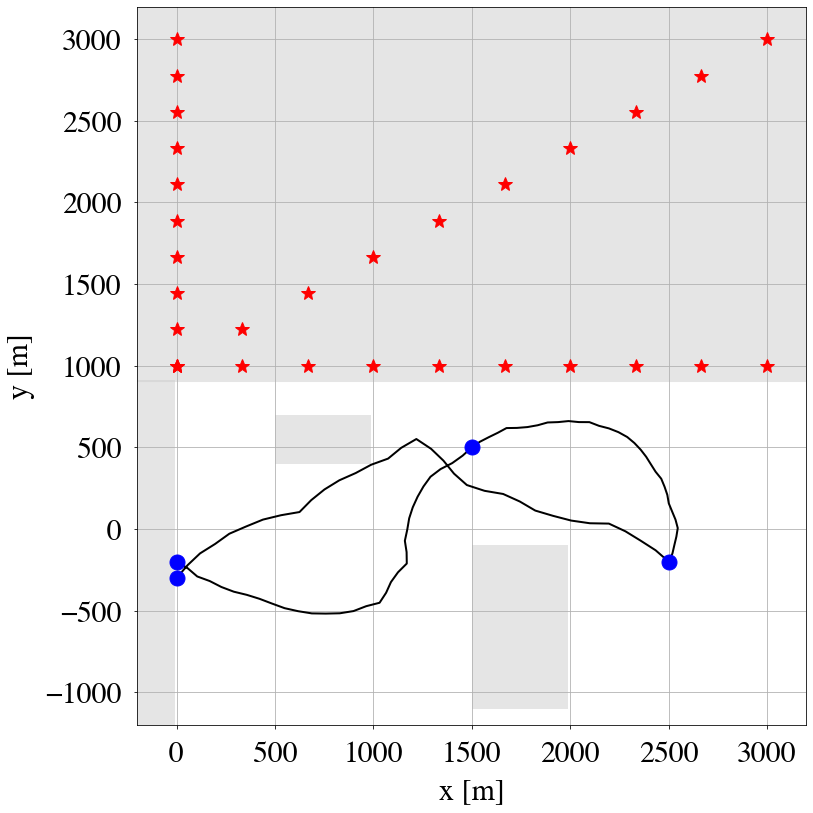

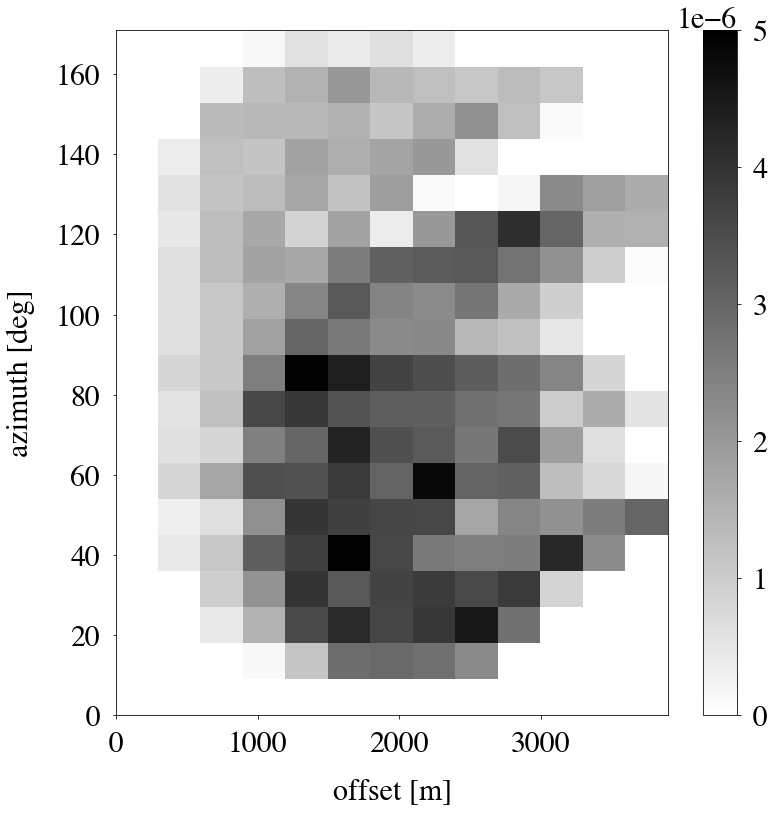

In [13]:
# Plot optimal layout.
ka.plot(x0,y0,x_opt,y_opt,xs,ys,filename='./OUTPUT/final_geometry.png')

# Plot final histogram and misfit.
xc_opt,yc_opt=ka.make_channel_coordinates(x_opt,y_opt,dl)
chi=chi_distance_azimuth(xs,ys,xc_opt,yc_opt,plot=True,filename='./OUTPUT/final_histogram.png')

In [14]:
n=len(x_opt)
l_opt=np.sqrt((x_opt[1:n]-x_opt[0:n-1])**2 + (y_opt[1:n]-y_opt[0:n-1])**2)
np.sum(l_opt)

6983.658394189435

In [15]:
#np.save('./OUTPUT/x_05.npy',x_opt)
#np.save('./OUTPUT/y_05.npy',y_opt)

In [16]:
# Include topography.